<a href="https://colab.research.google.com/github/Malisha4065/PyTorch-Workshop/blob/main/CNNDemoTL_Student_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Implementation with PyTorch

Dataset: CIFAR10 (Ref: https://www.cs.toronto.edu/~kriz/cifar.html)
Info: <br>
> Number of Images: 60000,  32 * 32 in resolution
> Number of Classes: 10 (Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck)

**Prerequisites**
> PyTorch Basics: https://youtu.be/OIenNRt2bjg
> Python Basics: https://youtu.be/rfscVS0vtbw

**References:**
1. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
2. https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-Regularization-in-PyTorch--VmlldzoxNTgwOTE
3. https://medium.com/artificialis/dropout-regularization-using-pytorch-in-python-7765337cb158
3. https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py
4. https://pytorch.org/vision/main/datasets.html
5. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
6. https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html#:~:text=Tensors%20are%20a%20specialized%20data,GPUs%20or%20other%20hardware%20accelerators.

## Mount google drive

In [1]:
# mounting google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the Necessary Libraries

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import models

## Define transforms (Data Augmentation)

In [3]:
# Define transforms

# For training set
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
# For testing set
transform_test = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

**Tensors**
> - Tensors are a specialized data structure that are very similar to arrays and matrices. In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.
> - Tensors are similar to NumPy’s ndarrays, except that tensors can run on GPUs or other hardware accelerators. In fact, tensors and NumPy arrays can often share the same underlying memory, eliminating the need to copy data.
> - Tensors are also optimized for automatic differentiation.


# Load datasets and define the

Torchvision provides many built-in datasets in the torchvision.datasets module, as well as utility classes for building your own datasets (https://pytorch.org/vision/main/datasets.html).

> PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

In [4]:
# Load datasets

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_train)

100%|██████████| 170498071/170498071 [00:13<00:00, 12909022.43it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# Define batch size
batch_size = 25

# Created dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

**Try!**
Here we have used only two sets are training and the testing tests. However, for the hyperparameter tuning we need the validation set as well. Therefore, find out a solution to split the test set into two and, redo the dataset loading and dataloader preparation.

In [6]:
# Define the classes in the dataset
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Display a Sample of Images

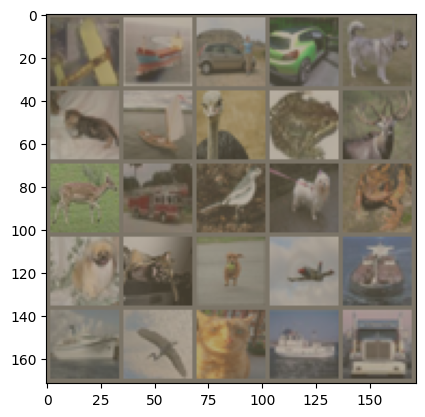

NameError: name 'j' is not defined

In [32]:
# Visualize a batch of images

def imshow(img):

    # Define transform to inverse normalize a image
    inv_normalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )

    # Inverse normalize the image
    img = inv_normalize(img)

    # Convert image into a Numpy Array for data manipuation and usage in
    # matplotlib
    npimg = img.numpy()
    # In numpy images defined as no. of channels, height, width format
    # However, matplotlib expects in height, width, channels format
    # So, we need to transform the npimg.
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images, nrow=5))

# Print labels
print(' '.join(f'{classes[labels[j]]}'))

## Define CNN

In [8]:
# Load pretrained model of ResNet18
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1, 0)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(16*6*6, 144)
        self.bn3 = nn.BatchNorm1d(144)
        self.fc2 = nn.Linear(144, 72)
        self.fc3 = nn.Linear(72, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimentions except batch
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [9]:
# Freeze the parameters
# So, during the training the the values of these parameters will not be updated



In [ ]:
# Create the CNN model


In [10]:
# Initialize a instance of the model
model = CNN()

## Define the Device

In [11]:
# If cuda GPU is available, it will be set as the device otherwise cpu
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
device

'cuda'

In [ ]:
# Transfer model to the device
model.to(device)

In [14]:
# Generate  model summary
summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
       BatchNorm2d-2            [-1, 6, 28, 28]              12
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 12, 12]             880
       BatchNorm2d-5           [-1, 16, 12, 12]              32
         MaxPool2d-6             [-1, 16, 6, 6]               0
            Linear-7                  [-1, 144]          83,088
       BatchNorm1d-8                  [-1, 144]             288
           Dropout-9                  [-1, 144]               0
           Linear-10                   [-1, 72]          10,440
           Linear-11                   [-1, 10]             730
Total params: 95,926
Trainable params: 95,926
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

## Define the Loss Function and Optimizer

In [15]:
# Define loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Train the model

In [19]:
# Train the defined model
for epoch in range(25): # loop over the dataset
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients

        # PyTorch, by default, accumulates gradients during the backward() pass of backpropagation
        # This means that the calculated gradients from each mini-batch of data are added to any
        # existing gradients from earlier mini-batches

        # To ensure that a parameter update during training reflects the gradients of the current batch of data (and not a mix of past data),
        # it's crucial to clear those old gradients before calculating the new ones.
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 2000 == 1999:
          print(f"[{epoch + 1}, {i + 1: 5d}] loss: {running_loss / 2000: .3f}")
          running_loss = 0.0

print("Training Done!")

[1,  2000] loss:  0.931
[2,  2000] loss:  0.920
[3,  2000] loss:  0.916
[4,  2000] loss:  0.911
[5,  2000] loss:  0.899
[6,  2000] loss:  0.896
[7,  2000] loss:  0.883
[8,  2000] loss:  0.878
[9,  2000] loss:  0.877
[10,  2000] loss:  0.871
[11,  2000] loss:  0.863
[12,  2000] loss:  0.864
[13,  2000] loss:  0.849
[14,  2000] loss:  0.848
[15,  2000] loss:  0.844
[16,  2000] loss:  0.841
[17,  2000] loss:  0.837
[18,  2000] loss:  0.829
[19,  2000] loss:  0.827
[20,  2000] loss:  0.823
[21,  2000] loss:  0.824
[22,  2000] loss:  0.812
[23,  2000] loss:  0.809
[24,  2000] loss:  0.804
[25,  2000] loss:  0.801
Training Done!


## Model Saving and Loading

In [23]:
# Saving
PATH = '/content/drive/MyDrive/AI/cifar_net_demo.pth'
torch.save(model.state_dict(), PATH)

In [22]:
# Loading
model = CNN()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [24]:
# Once more send the model to the device after loading
model.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=576, out_features=144, bias=True)
  (bn3): BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=144, out_features=72, bias=True)
  (fc3): Linear(in_features=72, out_features=10, bias=True)
)

## Performance with Testset

In [26]:
# Measure performance of the test set
correct = 0
total = 0

# Since we're not training, we don't need to calculate the gradients for the outputs
with torch.no_grad():
  for data in testloader:
    images,labels = data[0].to(device), data[1].to(device)

    # Calculate the outputs
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on 10000 test: {100*correct / total}%")

Accuracy of the network on 10000 test: 65.86%


**Try!** The method we have used here known as freezing, there is another popular method in Transfer Learning that known as fine-tuning. Even though these names use interchangbly, they means to complte different things. Try to redo the task with fine-tuning instead of freezing by yourself :)

**Try!**
In the above cases, we did not utilized any validation set and no hyperparameter tuning has been performed either. So model performance should be able to improve by performing some hyperparameter tuning.

**Try!**
Furthermore, try to measure the training and validation set losses/accuracies within the training loop and plot them in a single plot. In this way, we will be able to identify whether model is overfitting or not. In the above case, neither training or validation losses/accuracies were calculated. Try to record the performance once per certain number of batches.

**Try!**
Try to integrate early stopping into the training loop when the model performance w.r.t the validation set is no longer improving with further training. Try to think of a possible logic and add that into the training loop accordingly.

## Performance for Different Classes

In [30]:
# Measure the performance w.r.t each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)

    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

    for label, prediction in zip(labels, predictions):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

  for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class {classname:5s} is {accuracy:.1f}%")

Accuracy for class airplane is 70.7%
Accuracy for class automobile is 78.8%
Accuracy for class bird  is 54.4%
Accuracy for class cat   is 42.5%
Accuracy for class deer  is 63.6%
Accuracy for class dog   is 56.5%
Accuracy for class frog  is 74.2%
Accuracy for class horse is 68.4%
Accuracy for class ship  is 77.3%
Accuracy for class truck is 74.0%
